# Prediction & Visualization by geospatial & weather data For Uber Drivers

## Abstraction:
### The time spent on road primarily depends on multiple perspectives: Regions, weather, accidents etc. For taxi or Uber driver, how to avoid traffic congestion and achieve benefit maximization? In details:
### (1)	How could the drivers keep track of the traffic situation by animation?
### (2)	How could drivers acquire the distribution information about requests number? 
### For these questions, the focus of paper is to:
### (1)	Animate the traffic and visualize requests number by geospatial information.
### (2)	Explore how weather data impacts the traffic with data via FLARE.
### (3)	Predict the total ride duration of taxi trips in New York.  


## Introduction:
### For leveraging the traffic resources and avoid traffic jam, the synthetic traffic monitoring and prediction are necessary. 
### For this goal, diverse sorts of data in the system should be considered:
### (1)	In terms of weather, it is shown that tremendous range of weather/climate condition may (not must) affect the traffic, according to the ‘Road Weather Management program’. [1] 
### (2)	For drivers, the heatmap of hour changing will directly reflect the hot areas of traffic. Additionally, the prediction on duration trip will be more accurate to get to know what the hot area will be and show the hot areas predicted for the drivers. 
### (3)	Besides, they could keep track which regions have the most number of requests and they could receive the traffic information from operation center, so that they could balance and make a decision to achieve benefit maximization.  


In [10]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from haversine import haversine
import datetime as dt

# plotly.offline.init_notebook_mode()

## Step1: Load Data

In [11]:
'''Step1: Load Data'''
trainDF = pd.read_csv('data/train.csv', nrows=50000)
testDF = pd.read_csv('data/test.csv')
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", list(trainDF))


Size of the training set is: 50000 rows and 11 columns

 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


## Step 2: Understand Data

In [12]:
'''Step2: Understand Data'''
df = trainDF.describe()
print (df)

print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

dtypeDF=trainDF.dtypes.reset_index()# reset_index(): When we reset the index, the old index is added as a column, and a new sequential index is usedWhen we reset the index, the old index is added as a column, and a new sequential index is used
dtypeDF.columns=["Count","Column Type"]
dtypeDF.groupby("Column Type").aggregate('count')
print(dtypeDF)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  50000.000000     50000.000000      50000.000000     50000.000000   
mean       1.529440         1.667260        -73.973477        40.751211   
std        0.499138         1.316442          0.037974         0.027994   
min        1.000000         1.000000        -74.393555        40.449749   
25%        1.000000         1.000000        -73.991760        40.737579   
50%        2.000000         1.000000        -73.981644        40.754425   
75%        2.000000         2.000000        -73.967079        40.768513   
max        2.000000         6.000000        -73.518051        41.091171   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       50000.000000      50000.000000   50000.000000  
mean          -73.973374         40.752025     949.708280  
std             0.036672          0.032536    3175.391374  
min           -74.398514         40.444698       1.000000  
25%           -73.991348

## Step 3: Understanding distribution of target variable, catch outliers and replot.

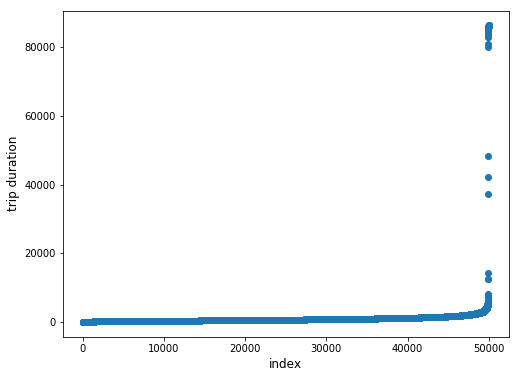

In [13]:
'''Step3: Understanding distribution of target variable i.e trip duration.'''
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))#Y.shape is (n,m). So Y.shape[0] is n.

#Step3.1: Find the outliers & Remove outliers by sorting duration in ascending order:
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

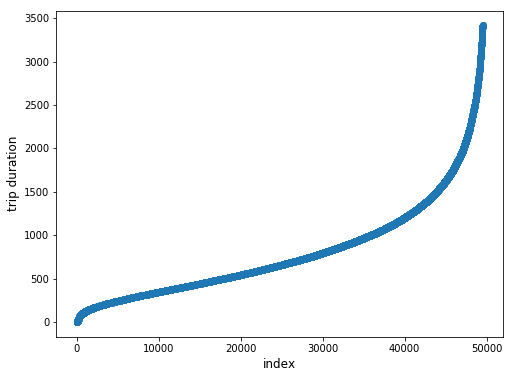

In [14]:
#Step3.2: Catch outliers and replot
th=trainDF.trip_duration.quantile(0.99)
tempDF=trainDF
tempDF=tempDF[tempDF['trip_duration']<th] #!!!!!!!!!!!!!!! Remain the ones <th
plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]),np.sort(tempDF.trip_duration.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('trip duration',fontsize=12)
plt.show()
del tempDF

## Step 4: Dealing with missing values.

In [15]:
#Step 4: Dealing with missing values
variable_missing_value=trainDF.isnull().sum()
print('Missing value number of Training DF:\n',variable_missing_value)
variable_missing_value=testDF.isnull().sum()
print('Missing value number of Testing DF:\n',variable_missing_value)

Missing value number of Training DF:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Missing value number of Testing DF:
 id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


## Step 5: Format the date time & Y/N values:

### Some of them with '02-23-2016' and '23/02/2016', so I have to unify the format.

In [16]:
#Step 5: Format the date time & Y/N values:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()
train = trainDF
test = testDF
del trainDF, testDF

In [17]:
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:,'pickup_date']=train['pickup_datetime'].dt.date
test.loc[:,'pickup_date']=test['pickup_datetime'].dt.date

train['dropoff_datetime']=pd.to_datetime(train.dropoff_datetime)

train['store_and_fwd_flag']=1*(train.store_and_fwd_flag.values=='Y')
test['store_and_fwd_flag']=1*(test.store_and_fwd_flag.values=='Y') #!!!!!!!!!!!!!!!!!
print(test.head(4))
print(list(train))

          id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:00                1   
1  id3505355          1 2016-06-30 23:59:00                1   
2  id1217141          1 2016-06-30 23:59:00                1   
3  id2150126          2 2016-06-30 23:59:00                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   

   store_and_fwd_flag pickup_date  
0                   0  2016-06-30  
1                   0  2016-06-30  
2                   0  2016-06-30  
3                   0  2016-06-30  
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitud

In [18]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds()) 
#!!!!!!!!! 1. New column 2. Convert to seconds.
duration_difference=train[np.abs(train['check_trip_duration'].values-train['trip_duration'].values) > 1] #!!!!!!!!!!!Remain the ones with abs>1
print('Trip_Duration & datetime are ok.')
print(list(train))

Trip_Duration & datetime are ok.
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration']


## Let check the description of data again. 

In [19]:
if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']])==0:
    print('Items of Duration_difference are 0.')

train['trip_duration'].describe()


count    50000.000000
mean       949.708280
std       3175.391374
min          1.000000
25%        395.000000
50%        659.000000
75%       1071.000000
max      86357.000000
Name: trip_duration, dtype: float64

## Step6: Feature Extraction:

## Principal components analysis (PCA): is used to extract the important information from a multivariate data table and to express this information. These new variables correspond to a linear combination of the originals. The number of principal components is less than or equal to the number of original variables.

In [20]:
#Step6: Feature Extraction:
# np.vstack: Stack arrays in sequence vertically (row wise).
coords=np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                  train[['dropoff_latitude', 'dropoff_longitude']].values,
                  test[['pickup_latitude', 'pickup_longitude']].values,
                  test[['dropoff_latitude', 'dropoff_longitude']].values))

pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0] 
#transform(X):Apply dimensionality reduction to X.
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]
#[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ],you get all values in column 0 (from all rows).
#df[['a','b']]: select multiple columns.

## Refer: For haversine_Array: http://mlwhiz.com/blog/2017/09/14/kaggle_tricks/

## Step7: Define Distance functions to process average speed and hot area:

In [21]:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2=map(np.radians, (lat1,lng1,lat2,lng2))
    AVG_EARTH_RADIUS=6371 #km
    lat=lat2-lat1
    lng=lng2-lng1
    d=np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h=2*AVG_EARTH_RADIUS*np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1,lng1,lat2,lng2):
    a=haversine_array(lat1,lng1,lat1,lng2)
    b=haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1,lng1,lat2,lng2):
    AVG_EARTH_RADIUS=6371
    lng_delta_rad=np.radians(lng2-lng1)
    lat1,lng1,lat2,lng2=map(np.radians,(lat1,lng1,lat2,lng2)) #np.radians(): Convert angles from degrees to radians
    y=np.sin(lng_delta_rad)*np.cos(lat2)
    x=np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

## Step 7.1: Generate distance dimension based on previous processing. On both of train and test data.

In [22]:
print('train headers:\n',list(train))
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2


train headers:
 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']


## Step8: Generate Datetime features for speed and weather analysis:

In [23]:
#Step8: Datetime features:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_hour_weekofyear']=train['pickup_datetime'].dt.weekofyear
train.loc[:,'pickup_hour']=train['pickup_datetime'].dt.hour
train.loc[:,'pickup_minute']=train['pickup_datetime'].dt.minute
train.loc[:,'pickup_dt']=(train['pickup_datetime']-train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:,'pickup_week_hour']=train['pickup_weekday']*24+train['pickup_hour']

test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_hour_weekofyear']=test['pickup_datetime'].dt.weekofyear
test.loc[:,'pickup_hour']=test['pickup_datetime'].dt.hour
test.loc[:,'pickup_minute']=test['pickup_datetime'].dt.minute
test.loc[:,'pickup_dt']=(test['pickup_datetime']-test['pickup_datetime'].min()).dt.total_seconds()
test.loc[:,'pickup_week_hour']=test['pickup_weekday']*24+test['pickup_hour']

train.loc[:,'week_delta']=train['pickup_datetime'].dt.weekday+((train['pickup_datetime'].dt.hour+(train['pickup_datetime'].dt.minute/60.0))/24.0)
test.loc[:,'week_delta']=test['pickup_datetime'].dt.weekday+((test['pickup_datetime'].dt.hour+(test['pickup_datetime'].dt.minute/60.0))/24.0)


## Step 8.1: Make time cyclic: 
## A cyclic period identifies repetitive cyclical variation, such as the number of months in a year or the number of days in a week.

In [24]:
#Step 8.1: Make time cyclic: 
## A cyclic period identifies repetitive cyclical variation, such as the number of months in a year or the number of days in a week.
train.loc[:,'week_delta_sin']=np.sin((train['week_delta']/7)*np.pi)**2
train.loc[:,'hour_sin']=np.sin((train['pickup_hour']/24)*np.pi)**2
test.loc[:,'week_delta_sin']=np.sin((test['week_delta']/7)*np.pi)**2
test.loc[:,'hour_sin']=np.sin((test['pickup_hour']/24)*np.pi)**2

## Step9: Speed processing:
### Get Average speed for regions.

In [25]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],3)


In [26]:
#Step9.1: Average speed for regions:
gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index() #!!!!!!!reset_index()
coord_stats=pd.merge(coord_speed, coord_count,on=gby_cols)
coord_stats=coord_stats[coord_stats['id']>100]

train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)
train.loc[:,'pickup_dt_bin']=(train['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)
test.loc[:,'pickup_dt_bin']=(test['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line


## Step10: Clustering & Predict by-MiniBatchKMeans:

## The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time.
## Mini-batches are subsets of the input data, randomly sampled in each training iteration. 
## These mini-batches drastically reduce the amount of computation required to converge to a local solution. 

In [27]:
#Step10: Clustering-MiniBatchKMeans:
sample_ind=np.random.permutation(len(coords))[:500000]
#np.random.permutation: Randomly permute a sequence, or return a permuted range.
#Shuffle the coords and get 500000 items from it.

print('the length of coords:\n', len(coords))

kmeans=MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
#MiniBatchKMeans: batch_size controls the number of randomly selected observations in each batch. 
# The larger the the size of the batch, the more computationally costly the training process.


the length of coords:
 1350268


## Step10.1: Predict by MiniBatchKMeans:(Keypoint)

In [28]:
#Step10.1: Predict by MiniBatchKMeans:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

t1=dt.datetime.now()
print('Time for clustering: %i seconds' %(t1-t0).seconds) #!!!!!!!!!!!!!!!!!!!!


Time for clustering: 260 seconds


In [29]:
train['log_trip_duration']=np.log(train['trip_duration'].values+1)

In [30]:
print(list(test))
print("\n")
print("Train:")
print(list(train))
print(train.head(3))

['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_cluster', 'dropoff_cluster']


Train:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direct

## Step11: Temporal and geospatial aggregation: 
### For retriving the trips over threshold time durations and identifying hot areas.

In [31]:
#Step11: Temporal and geospatial aggregation
for gby_col in ['pickup_hour','pickup_date','pickup_dt_bin','pickup_week_hour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_col).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns=['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train=pd.merge(train, gby,how='left',left_on=gby_col,right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    #how: left: use only keys from left frame, similar to a SQL left outer join; preserve key order
    #right_index: Use the index from the right DataFrame as the join key.
    #left_on 和 right_on 来指定列名，从而使不同的列名相互对应，进而进行合并. 如employee, name.


for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats=pd.merge(coord_speed,coord_count,on=gby_cols)
    coord_stats.columns=gby_cols+['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    #.columns attribute returns an index containg the column names of df.
    # df. columns可以得到所有的列标签，同理df.index可以得到所有的行标签。
    #eg.:df.columns: Get: Index(['ColumnOne', 'ColumnTwo'], dtype=
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)
 

In [32]:
print(list(test))
print("\n")
print("Train:")
print(list(train))
print(train.head(3))


['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_

## Step12: Get trips around 60 min.

In [33]:
   
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag          ...            \
0         40.765602                   0          ...             
1         40.731152                   0          ...             
2         40.710087                   0          ...             

   cnt_center_lat_bin_center_long_bin  \
0                                2020   
1                                1803   
2                                2823 

In [34]:
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag     ...       \
0         40.765602                   0     ...        
1         40.731152                   0     ...        
2         40.710087                   0     ...        

   avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406        
1                                           3.419741        
2                 

## Count how many trips are going from each cluster over time

In [35]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

In [36]:
train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)


## Step 13: import OSRM data for further processing.

### For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ "OSRM")) features. This data contains the fastest routes from specific starting points in NY.

In [99]:
fr1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])

fr2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

test_street_info = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])


In [38]:
train_street_info=pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag       ...         \
0         40.765602                   0       ...          
1         40.731152                   0       ...          
2         40.710087                   0       ...          

   avg_speed_h_pickup_hour_dropoff_cluster cnt_pickup_hour_dropoff_cluster  \
0                                 2.803846                              59   
1                            

## Step 14: Feature extraction..
### This step is to filter the features we used.

In [39]:
#Filter the features we used.
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns)) #setdiff1d():Return the sorted, unique values in ar1 that are not in ar2.
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print('We have %i features.' % len(feature_names))
train[feature_names].count()

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 61 features.
Feature extraction time: 296 seconds


## Feature check before modeling

In [40]:
feature_stats = pd.DataFrame({'feature': feature_names})

feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
# axis=0:the first running vertically downwards across rows (axis 0), 
# and the second running horizontally across columns (axis 1)

#np.nanmean(): Compute the arithmetic mean along the specified axis, ignoring NaNs.
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()


,feature,train_test_mean_diff
54,avg_speed_h_pickup_cluster_dropoff_cluster,0.030330
55,cnt_pickup_cluster_dropoff_cluster,0.035511
51,cnt_pickup_hour_pickup_cluster,0.042442
48,avg_speed_h_pickup_hour_center_lat_bin_center_...,0.045448
53,cnt_pickup_hour_dropoff_cluster,0.050175


## Step 14: Train a simple classifier for prediction trip duration(keypoint):

## Step 14.1: use the TPOT package to handle the cross validation and hyperparameters

In [41]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=9, verbosity=2)
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Version 0.9.2 of tpot is outdated. Version 0.9.3 was released Monday April 09, 2018.


### Split the training data to train and validate

In [42]:
# K Fold Cross Validation
from sklearn.model_selection import KFold

X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1) #SetTarget feature: trip_Duration.

kf = KFold(n_splits=10)
kf.get_n_splits(X)

print("feature names:\n", feature_names)
print("x:\n",X)
print("y:\n",y)
print(kf)  


feature names:
 ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_clu

In [43]:
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

TRAIN: [ 5000  5001  5002 ..., 49997 49998 49999] TEST: [   0    1    2 ..., 4997 4998 4999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [5000 5001 5002 ..., 9997 9998 9999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [10000 10001 10002 ..., 14997 14998 14999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [15000 15001 15002 ..., 19997 19998 19999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [20000 20001 20002 ..., 24997 24998 24999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [25000 25001 25002 ..., 29997 29998 29999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [30000 30001 30002 ..., 34997 34998 34999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [35000 35001 35002 ..., 39997 39998 39999]
TRAIN: [    0     1     2 ..., 49997 49998 49999] TEST: [40000 40001 40002 ..., 44997 44998 44999]
TRAIN: [    0     1     2 ..., 44997 44998 44999] TEST: [45000 45001 45002 ..., 49997 49998 49999]


### Train the data by classifier.

In [44]:
auto_classifier.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -0.14699252836330726


Generation 2 - Current best internal CV score: -0.14699252836330726


Generation 3 - Current best internal CV score: -0.14699252836330726



Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100, nthread=1, subsample=1.0)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=3, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=9, periodic_checkpoint_folder=None,
       population_size=9, random_state=None, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

## Step14.2: Save the test[feature_names] to csv file.

In [45]:
print(feature_names)
print(test[feature_names].head(5))
test[feature_names].to_csv('NYCTaxi_DataTest.csv', index=False)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

## Step 15: Predict trip duration with classifier.(Keypoint)

In [47]:
test_result = auto_classifier.predict(test[feature_names].values)
print(auto_classifier.score(X_valid,y_valid))

sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = np.exp(test_result) 
#np.exp: Calculate the exponential of all elements in the input array.
sub['pickup_weekday']=test['pickup_weekday']
sub.to_csv('NYCTaxi_TpotModels.csv', index=False)
sub.head()
      
auto_classifier.export('NYCTaxi_TPOTpipelineResult.py')

Imputing missing values in feature set
-0.150391085454


True

In [48]:
trainDF = pd.read_csv('NYCTaxi_DataTest.csv', nrows=10000)
print(trainDF.isnull().any())

vendor_id                                                 False
passenger_count                                           False
pickup_longitude                                          False
pickup_latitude                                           False
dropoff_longitude                                         False
dropoff_latitude                                          False
store_and_fwd_flag                                        False
pickup_pca0                                               False
pickup_pca1                                               False
dropoff_pca0                                              False
dropoff_pca1                                              False
distance_haversine                                        False
distance_dummy_manhattan                                  False
direction                                                 False
pca_manhattan                                             False
center_latitude                         

In [49]:
#Fill nan of columns:
trainDF['avg_speed_h_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_pickup_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_pickup_cluster'].fillna((trainDF['cnt_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_dropoff_cluster'].fillna((trainDF['cnt_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_cluster_dropoff_cluster'].fillna((trainDF['cnt_pickup_cluster_dropoff_cluster'].mean()), inplace=True)


#  Step 15: Animation the map with time changing:(Keypoint)

In [50]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
# from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Step 15.1: Load data & Processing.

In [51]:
s = time.time()
train_fr_1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

train_df = pd.read_csv('data/new-york-city-taxi-with-osrm/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken: {}.".format((end-s)))

Time taken: 40.0965211391449.


### Checking if Ids are unique, and the number of Nulls.

In [52]:
# checking if Ids are unique, and the number of Nulls.
start = time.time()
train_data = train_df.copy()
start = time.time()
print("Respectively, number of columns and rows and columns are {} and {} .".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]: #nunique(): Return number of unique elements in the object.
    print("Train ids are unique")
print("Number of Nulls : {}.".format(train_data.isnull().sum().sum()))

# Remain the items with latitude & longitude between 40.6-40.9 and -74.05--73.7:
%matplotlib inline

df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]

train_data_new = df.copy()
print(train_data_new.head(4))
end = time.time()
print("Time taken {}.".format(end-start))

Respectively, number of columns and rows and columns are 14 and 1458644 .
Train ids are unique
Number of Nulls : 3.
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   
1         4

## Step 15.2: Processing the information: like checking if trip duration has some correlation with vendors/drivers.

In [53]:
temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

train_data = temp


# Step 16: Basic image processing

##  Consider each point of this image as a point represented by lat-long. Then take a summary of lat-long and their count, assign a different color for different count range.

## Step 16: Initialize and handle the pick&drop lat-long for further plot.

In [54]:
# rbg[lat, long, 0/1/2]:Create 3 arrays: with 3500 rows & 3 columns each.
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8) # 3000 arrays: with 3500 rows & 3 columns each.
rgb[..., 0] = 0 # Assign 0 to every items in column 0;
rgb[..., 1] = 0 # Assign 0 to every items in column 1;
rgb[..., 2] = 0 # Assign 0 to every items in column 2;

train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))
# map(): typecasting every element of the list to an integer value. 
# latitude should be between 40.6 to 40.9; Longitude should be between -74.05 to -73.70
summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

#Print new train data after transformation:
print('pickup_latitude:\n',train_data_new['pick_lat_new'].head(3))
print('dropoff_latitude:\n',train_data_new['drop_lat_new'].head(3))
print('pickup_longitude:\n',train_data_new['pick_lon_new'].head(3))
print('dropoff_longitude:\n',train_data_new['drop_lon_new'].head(3))
# print('summary_plot:\n')
# summary_plot.head(100)

pickup_latitude:
 0    1679
1    1385
2    1639
Name: pick_lat_new, dtype: int64
dropoff_latitude:
 0    1656
1    1311
2    1100
Name: drop_lat_new, dtype: int64
pickup_longitude:
 0    678
1    695
2    709
Name: pick_lon_new, dtype: int64
dropoff_longitude:
 0    853
1    505
2    446
Name: drop_lon_new, dtype: int64


## Step 17: Plot geograph:

Time taken by above cell is 35.32198882102966.
unit: [1]


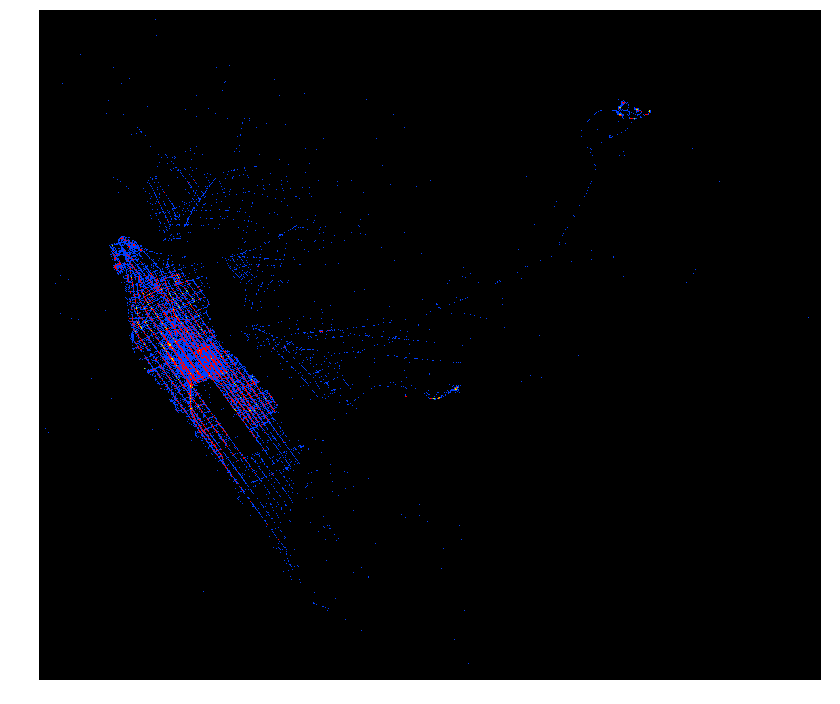

In [55]:
summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()

for i in lat_list: #lat_list: list of unique 'pick_lat_new'
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    # Get the longitude mapping with unique latitude.
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    # Get the id mapping with unique latitude.
    
    for j in lon_list: 
        a = unit[lon_list.index(j)] # lon_list.index(j): return the index of lon_list(j)
        if (a//50) >0: # //: Floor Division: the result is the quotient in which the digits after decimal points are not taken into account.
            rgb[i,j, 0] = 191 #Label the count>50 with Green
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        elif (a//10)>0: #Label the count>10 with Red
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        else: #Label the count>10 with blue
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 64
            rgb[i,j, 2] = 255

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
#plt.subplots():Create a figure and a set of subplots.
#nrows, ncols : int, optional, default: 1. Number of rows/columns of the subplot grid.
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot') 
#ax.imshow():Display an image on the axes.
ax.set_axis_off() 

print('unit:',unit)


# Animation of pickups hot area: 

## The bearing & manhattan distance: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

## Step 18: Define some distance functions.

In [1]:

start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

NameError: name 'time' is not defined

## Step 19: Feature extratction

## Define funtions to unfold features:
##  Find out features which are affecting the trip-duration between a given pickup and drop-off locations. 

In [57]:
start = time.time()
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 7.716070175170898.


# Animation of pickups
## Step 20: Make an animation of pickup and see how with pickup hours the traffic changes

## https://www.kaggle.com/jiexus/strength-of-visualization-python-visuals-tutorial

## Step 20.1: Define some functions for animiation:
## making similar heatmaps of pickup locations for different pickup hours，and then will make a gif of those images in order of increasing pickup hour.

In [58]:
start = time.time()
def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a pic of plotings"""
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

    summary_plot.reset_index(inplace = True)
    summary_plot.head(120)
    
    lat_list = summary_plot['pick_lat_new'].unique()
    for i in lat_list:
        
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            
            if (a//50) >0:
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)

    end = time.time()
    print("Time taken by above cell is {} for {}.".format((end-start), hour))
    return(rgb)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

Time taken by above cell is 0.001001119613647461.


## Step 20.2: makes bunches of images according to hours.

In [59]:
start = time.time()
images_list=[]
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)):
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anacond

Time taken by above cell is 5.156708002090454 for 0.
Time taken by above cell is 3.525372266769409 for 1.
Time taken by above cell is 4.010663270950317 for 2.
Time taken by above cell is 3.1990041732788086 for 3.
Time taken by above cell is 3.2506468296051025 for 4.
Time taken by above cell is 3.0897133350372314 for 5.
Time taken by above cell is 3.897372007369995 for 6.
Time taken by above cell is 4.428772926330566 for 7.
Time taken by above cell is 4.6623945236206055 for 8.
Time taken by above cell is 3.651207208633423 for 9.
Time taken by above cell is 3.598064422607422 for 10.
Time taken by above cell is 3.6918153762817383 for 11.
Time taken by above cell is 3.9289445877075195 for 12.
Time taken by above cell is 4.197162866592407 for 13.
Time taken by above cell is 4.820313930511475 for 14.
Time taken by above cell is 4.103408336639404 for 15.
Time taken by above cell is 3.820171594619751 for 16.
Time taken by above cell is 4.214704513549805 for 17.
Time taken by above cell is 4.13

## Step 20.2: Define a function to build and save gif.
## Rule: Generate individual picture according to hours-->img_list-->pass the list into build_gif().

In [60]:
start = time.time()

def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    def show_im(pairs):
        ax.clear()
        ax.set_title('Traffic- Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off() 
    pairs = list(zip(hr_range, imgs))
    
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False)
    plt.cla() #Clear the current axes.
    if save_gif:
        plt.rcParams["animation.convert_path"] = "ImageMagick-7.0.7-Q16\convert.exe" #magick.exe
        im_ani.save('animation.gif', writer='imagemagick') #, writer='imagemagick'
    if show_gif:
        plt.show()
    return

end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.0


24.667829513549805


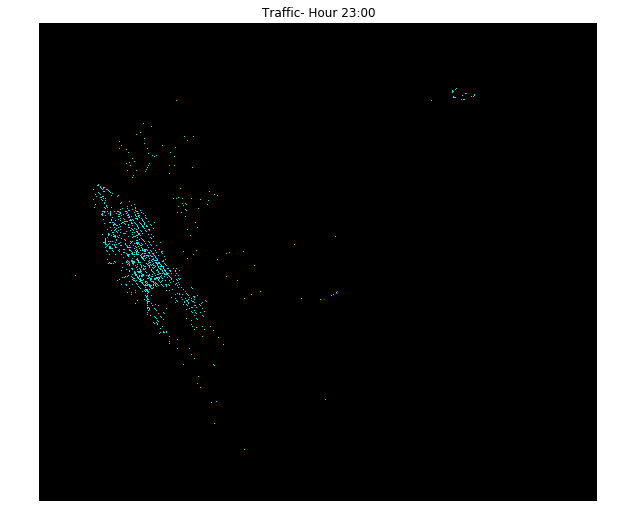

In [61]:
start = time.time()
build_gif()
end = time.time()
print(end-start)


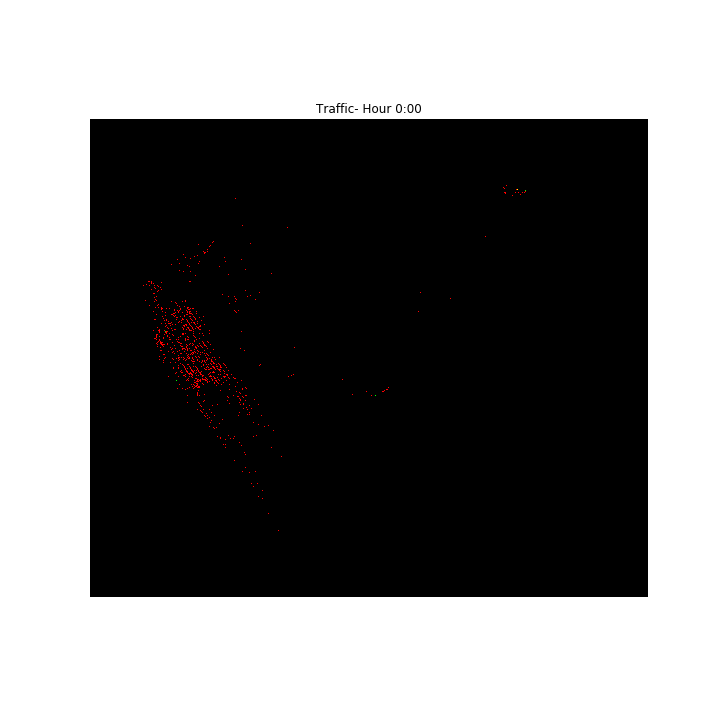

In [62]:
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## Check the changing .gif on Notebook.
## Findings:
## 1. The least number of request comes from time 2 AM-7 AM, from 7 AM -4 PM the requests were moderate in number, and from 5 PM-1 AM in night, there is a huge amount of request of cabs in all NYC.
## 2. The dot in the top right corner of this animation is JFK Airport: people are moving less between 2 AM to 6 AM with same rules.

# Features' Exploration (Checking if any explainable pattern)

## check if some other dimesions are related to trip duration: e.g.:the average time taken by two different vendors vs weekday

C:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



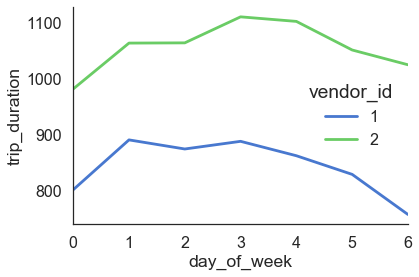

In [63]:
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

## Findings:
1. Vendor 1 is taking more time than vendor 2 on all the days of the week, we can also subset data frame based on the month and that will also give us the same results.  
2. The difference between the average time taken by vendor 1 is ~250 seconds more than vendor 2.

# Step 21: Cluster analysis and visualization

## Step 21.1: Define function to assign clusters.
## (predict the label_drop according to k_means_pick model.)

In [64]:
start = time.time()
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]

    #20 lat-log in init array.
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    #n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
    k_means_pick.fit(df_pick) #df_pick=df[['pickup_longitude','pickup_latitude']]
    
    clust_pick = k_means_pick.labels_
    
    df['label_pick'] = clust_pick.tolist()
    
    df['label_drop'] = k_means_pick.predict(df_drop) #df_drop = df[['dropoff_longitude','dropoff_latitude']]
    #predict the label_drop according to k_means_pick model.
    
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

time taken by thie script by now is 0.0005004405975341797.


## Step 21.2: Add Centroid to dataframe:

In [65]:

train_cl, k_means = assign_cluster(train_data, 20)  #K-means: n_clusters=20

#Generate Centroid of pickup/dropoff.
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index

#Add centroid to train_cl:
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()


## Step 21.3: Cluster related features:

## Generate following data:
## 1. Distance (haversine, mahnatten) between pickup-drop_off cluster centroids
## 2. Directional features - bearing direction between cluster centroids

In [66]:
start = time.time()
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))
print(train_cl.head())

Time Taken by above cell is 9.157856225967407.
          id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag      ...       hvsine_drop_cent_d  \
0         4

# Step 22： Cluster visualization using folium

## In the next, cluster summary function is to find the cluster characteristics of given cluster list( a cluster list is the list of significant clusters, not all clusters are significant in size.) So, a list of the significant cluster can be passed to summarized those clusters. Significant clusters are clusters having more than 70 thousand rides as the pickup location. Then we will make plots:
## 1. Showing pickups location on NYC map using stamen toner terrain
## 2. Showing all clusters on Map of America

## Step 22.1: Define a function to calculate summary of given list of clusters: groupby('label_pick')

In [67]:
start = time.time()
def cluster_summary(sum_df):
    #agg_func = {'trip_duration':'mean','label_drop':'count','bearing':'mean','id':'count'} 
    #that's how to use agg function with groupby
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)
    summary_pref_cluster = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_cluster = summary_pref_cluster.reset_index()
    summary_pref_cluster = summary_pref_cluster.loc[summary_pref_cluster.groupby('label_pick')['id'].idxmax()]
    summary =pd.merge(summary_avg_time, summary_pref_cluster, how = 'left', on = 'label_pick')
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    return summary


# Step 23: plot by Folium:

## Folium citing: http://folium.readthedocs.io/en/latest/quickstart.html

## Step 23.1: Define functions:
## 1. function to generate map and add the pick up and drop coordinates
## 2. the function is to plot clusters on map.

In [68]:
import folium
def show_fmaps(train_data, path=1):
    """function to generate map and add the pick up and drop coordinates
    1. Path = 1 : Join pickup (blue) and drop(red) using a straight line
    """
    full_data = train_data
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10)
    # manually added centre
    
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(50)
    #isin(): Return boolean DataFrame showing whether each element in the DataFrame is contained in values.
    
    new_df.reset_index(inplace = True, drop = True)
    
    for i in range(new_df.shape[0]): # :iterations: Get top of the label_pick with count in descent order.
        pick_long = new_df.loc[new_df.index ==i]['pickup_longitude'].values[0]
        pick_lat = new_df.loc[new_df.index ==i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index ==i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index ==i]['dropoff_latitude'].values[0]
        
        folium.Marker([pick_lat, pick_long]).add_to(map_1)#Add this label_pick(lat-long) to map.
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1


def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 25):
    """ the function is to plot clusters on map"""
    map_1 = folium.Map(location=[40.767923, -73.982168], zoom_start=zoom,tiles= tile) # 'Mapbox' 'Stamen Toner'
    
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    
    if sig == 1:
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
        
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data)
    
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
        
    return map_1

In [69]:
osm = show_fmaps(train_data, path=1)
osm

## Findings :
## 1. Clusters with more than 70k pickups are taken for plotting thismap, and they are covering about 80% of the rides
## 2. This maps shows that most of the rides are started from manhattan.

In [70]:
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =3.2, circle =1, tile = 'Stamen Terrain')
clus_map

## Findings:
## Plots are interactive click on balloon as check out the characteristics of each cluster:
## 1. Cluster number
## 2. Most frequently visited cluster from clicked cluster
## 3. Avg triptime of rides started from this cluster

# Step 25: Predict by XGB model for validation & comparision:

## 1. Extract same features for test dataset
## 2. Train xgboost regressor to see how we are doing with prediction, how much predicting power out extracted features have. 
## 3. If it did not get high accuracy, extra features will be extracted.

## The process:
## 1. Extract same features-->2. Train xgboost regressor-->3. If not accurate-->4. Extract more features.

## Step 25.1: Extracting same features for Test data

In [71]:
# 1. Loading test data from competition and OSRM features for test data
test_df = pd.read_csv('data/test.csv')
test_fr = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_test.csv')
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(test_df, test_fr_new, on = 'id', how = 'left')
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,total_travel_time,number_of_steps
0,id3004672,1,6/30/2016 23:59,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,424.6,4
1,id3505355,1,6/30/2016 23:59,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,200.0,4
2,id1217141,1,6/30/2016 23:59,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,193.2,4
3,id2150126,2,6/30/2016 23:59,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,494.8,11
4,id1598245,1,6/30/2016 23:59,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,103.2,4


### Extracting date time features

In [72]:
#2. Extracting date time features
start = time.time()
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 218.11219191551208.


### Extracting haversine, manhattan, and bearing distance and directional features 

In [73]:
#3. Extracting haversine, manhattan, and bearing distance and directional features 

test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, 
                                                 test_data['pickup_longitude'].values, 
                                                 test_data['dropoff_latitude'].values, 
                                                 test_data['dropoff_longitude'].values)

test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, 
                                                            test_data['pickup_longitude'].values, 
                                                            test_data['dropoff_latitude'].values, 
                                                            test_data['dropoff_longitude'].values)


test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, 
                                           test_data['pickup_longitude'].values, 
                                           test_data['dropoff_latitude'].values, 
                                           test_data['dropoff_longitude'].values)


In [74]:
# 4. Extracting cluster features
start = time.time()
test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])
test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])
#test_cl.head()
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 1.7501413822174072.




test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, 
                                                 test_data['pickup_longitude'].values, 
                                                 test_data['dropoff_latitude'].values, 
                                                 test_data['dropoff_longitude'].values)

test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, 
                                                            test_data['pickup_longitude'].values, 
                                                            test_data['dropoff_latitude'].values, 
                                                            test_data['dropoff_longitude'].values)


test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, 
                                           test_data['pickup_longitude'].values, 
                                           test_data['dropoff_latitude'].values, 
                                           test_data['dropoff_longitude'].values)


### Extracting haversine, manhattan, and bearing distance and directional features 

In [75]:
# 5. Extracting features: pickup/dropoff centroid of kinds of distances, and get aveage speed.

test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, 
                                                 test_cl['pickup_longitude'].values, 
                                                 test_cl['centroid_pick_lat'].values, 
                                                 test_cl['centroid_pick_long'].values)

test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, 
                                                 test_cl['dropoff_longitude'].values, 
                                                 test_cl['centroid_drop_lat'].values, 
                                                 test_cl['centroid_drop_long'].values)

test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, 
                                                   test_cl['centroid_pick_long'].values, 
                                                   test_cl['centroid_drop_lat'].values, 
                                                   test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, 
                                                            test_cl['pickup_longitude'].values, 
                                                            test_cl['centroid_pick_lat'].values, 
                                                            test_cl['centroid_pick_long'].values)

test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, 
                                                            test_cl['dropoff_longitude'].values, 
                                                            test_cl['centroid_drop_lat'].values, 
                                                            test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, 
                                                              test_cl['centroid_pick_long'].values, 
                                                              test_cl['centroid_drop_lat'].values, 
                                                              test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, 
                                                     test_cl['pickup_longitude'].values, 
                                                     test_cl['centroid_pick_lat'].values, 
                                                     test_cl['centroid_pick_long'].values)

test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, 
                                                     test_cl['dropoff_longitude'].values, 
                                                     test_cl['centroid_drop_lat'].values, 
                                                     test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, 
                                                       test_cl['centroid_pick_long'].values, 
                                                       test_cl['centroid_drop_lat'].values, 
                                                       test_cl['centroid_drop_long'].values)

test_cl['speed_hvsn'] = test_cl.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_cl.manhtn_pick_drop/test_cl.total_travel_time

test_cl.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id3004672,1,2016-06-30 23:59:00,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,...,0.460745,2.557813,0.316489,0.572701,2.657047,166.844158,163.485792,-2.267563,0.006468,0.006861
1,id3505355,1,2016-06-30 23:59:00,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,...,4.035734,0.000000,1.680995,4.786109,0.000000,-21.064990,-11.983231,0.000000,0.013796,0.015524
2,id1217141,1,2016-06-30 23:59:00,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,...,0.108194,1.520191,0.425801,0.128053,2.144081,-68.660074,-78.185424,130.816473,0.006761,0.009557
3,id2150126,2,2016-06-30 23:59:00,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,...,0.117694,5.622357,0.327942,0.166443,7.657602,29.968069,-134.876849,-150.583803,0.010649,0.014477
4,id1598245,1,2016-06-30 23:59:00,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,...,1.015384,0.000000,0.620567,1.234924,0.000000,-145.882392,-75.681715,0.000000,0.009310,0.013122


## Step 25.2: Import XGB Model

### Use XGBoost regressor for prediction. 
### 1. Train XGB on training features 
### 2. Use trained model for prediction.

In [76]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

## Step 25.3: Add PCA features in the model

In [77]:
train = train_cl
test = test_cl
start = time.time()
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 5.579331636428833.


In [78]:
# Replace with 0 or 1:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

## Step 25.4: Get the difference of features in train and test

In [79]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")

do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features are 39.


## Step 26.5: Split and train XGB model:

## xgb: http://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [80]:
y = np.log(train['trip_duration'].values + 1)
start = time.time()

Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
#train_test_split(): Split arrays or matrices into random train and test subsets.
#<random_state>:If int, random_state is the seed used by the random number generator.

dtrain = xgb.DMatrix(Xtr, label=ytr) #DMatrix: object of XGBoost
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)
#xgb.train(): xgboost.train(params, dtrain, num_boost_round=10, evals=(), obj=None, 
# feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, 
# xgb_model=None, callbacks=None, learning_rates=None):
#1. xgb_pars: params;
#2. dtrain: (DMatrix) – Data to be trained.
#3. 15: num_boost_round (int) – Number of boosting iterations.
#4. watchlist: (list of pairs (DMatrix, string)):List of items to be evaluated during training, this allows user to watch performance on the validation set.
#5. 2: early_stopping_rounds (int) – Activates early stopping. Validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training. 
#6. maximize=False: maximize (bool) – Whether to maximize feval.
#7. verbose_eval=1: The evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
end = time.time()

print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22632	valid-rmse:4.22757
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.97634	valid-rmse:2.9779
[2]	train-rmse:2.10627	valid-rmse:2.10828
[3]	train-rmse:1.50768	valid-rmse:1.51038
[4]	train-rmse:1.0977	valid-rmse:1.1013
[5]	train-rmse:0.82356	valid-rmse:0.828341
[6]	train-rmse:0.645152	valid-rmse:0.651593
[7]	train-rmse:0.535765	valid-rmse:0.54387
[8]	train-rmse:0.472743	valid-rmse:0.482233
[9]	train-rmse:0.437489	valid-rmse:0.448313
[10]	train-rmse:0.41794	valid-rmse:0.429668
[11]	train-rmse:0.407544	valid-rmse:0.419869
[12]	train-rmse:0.401203	valid-rmse:0.414095
[13]	train-rmse:0.398004	valid-rmse:0.411455
[14]	train-rmse:0.395435	valid-rmse:0.409449
Time taken by above cell is 152.3740096092224.
Modeling RMSLE 0.40945


# Step 26: Feature Extraction Round 2 with weather data
## By Extraction on following features as RMSLE is not going below 0.38
## 1. Pick to drop cluster
## 2. Drop to pickup cluster
## 3. Number of lefts
## 4. Number of rights ( 3,4 from osrm data)
## 5. Check weather in nyc dataset and see if it can be used as feature

## Step 26.1: Preprocess the data loaded:

In [81]:
weather = pd.read_csv('data/weather_data_nyc_centralpark_2016.csv')
weather[['precipitation']] = weather[['precipitation']].replace(np.nan, 'T', regex=True)
weather[['snow_fall']] = weather[['snow_fall']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_fall': 'snow fall'}, inplace=True)
weather[['snow_depth']] = weather[['snow_depth']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_depth': 'snow depth'}, inplace=True)
##minimum_temperature
weather.rename(columns={'minimum_temperature': 'minimum temperature'}, inplace=True)
weather.head(10)

,date,maximum_temperature,minimum temperature,average_temperature,precipitation,snow fall,snow depth
0,1/1/2016,42,34,38.0,0,0,0
1,2/1/2016,40,32,36.0,0,0,0
2,3/1/2016,45,35,40.0,0,0,0
3,4/1/2016,36,14,25.0,0,0,0
4,5/1/2016,29,11,20.0,0,0,0
5,6/1/2016,41,25,33.0,0,0,0
6,7/1/2016,46,31,38.5,0,0,0
7,8/1/2016,46,31,38.5,0,0,0
8,9/1/2016,47,40,43.5,T,0,0
9,10/1/2016,59,40,49.5,1.8,0,0


## Step 26.2: Filter and Map the format of data:

In [82]:
from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

weather.date = pd.to_datetime(weather.date)
weather['day_of_year']= weather.date.dt.dayofyear

weather['precipitation'].unique() #unique(): Returns the sorted unique elements of an array. 

weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00',weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation'])) 
# map() function applies a given function to each item of an iterable (list, tuple etc.) and returns a list of the results.
# so if you want a new list and not just something to iterate over, you either need list(map(float, mylist)

weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00',weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))

weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00',weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

weather.head(10)

C:\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning:

pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp

C:\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning:

The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead

C:\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



,date,maximum_temperature,minimum temperature,average_temperature,precipitation,snow fall,snow depth,day_of_year
0,2016-01-01,42,34,38.0,0.0,0.0,0.0,1
1,2016-02-01,40,32,36.0,0.0,0.0,0.0,32
2,2016-03-01,45,35,40.0,0.0,0.0,0.0,61
3,2016-04-01,36,14,25.0,0.0,0.0,0.0,92
4,2016-05-01,29,11,20.0,0.0,0.0,0.0,122
5,2016-06-01,41,25,33.0,0.0,0.0,0.0,153
6,2016-07-01,46,31,38.5,0.0,0.0,0.0,183
7,2016-08-01,46,31,38.5,0.0,0.0,0.0,214
8,2016-09-01,47,40,43.5,0.0,0.0,0.0,245
9,2016-10-01,59,40,49.5,1.8,0.0,0.0,275


## Step 26.3:Define function to create dummy for turn type

In [83]:
def freq_turn(step_dir):
    from collections import Counter
    
    step_dir_new = step_dir.split("|")
    a_list = Counter(step_dir_new).most_common()
    path = {}
    for i in range(len(a_list)):
        path.update({a_list[i]})
        
    a = 0
    b = 0
    c = 0
    
    if 'straight' in (path.keys()):
        a = path['straight']
        #print(a)
    if 'left' in (path.keys()):
        b = path['left']
        #print(b)
    if 'right' in (path.keys()):
        c = path['right']
        #print(c)
    return a,b,c


In [84]:
start = time.time()
train_fr['straight']= 0
train_fr['left'] =0
train_fr['right'] = 0
train_fr['straight'], train_fr['left'], train_fr['right'] = zip(*train_fr['step_direction'].map(freq_turn))
#The zip() function take iterables (can be zero or more), 
# makes iterator that aggregates elements based on the iterables passed, and returns an iterator of tuples.
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 42.86594486236572.


## Step 26.3: Merge direction information to data.

In [85]:
train_fr_new = train_fr[['id','straight','left','right']]
train = pd.merge(train, train_fr_new, on = 'id', how = 'left')
#train = pd.merge(train, weather, on= 'date', how = 'left')
print(len(train.columns))

47


# Step 27: Predict traffic with weather data.

## Step 27.1: Merge weather data, and add centroid information.

In [86]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['date'] = train['pickup_datetime'].dt.date
train.head()

train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
train.shape[0]

1458644

In [87]:
train.loc[:,'hvsine_pick_cent_d'] = haversine_(train['pickup_latitude'].values, 
                                               train['pickup_longitude'].values, 
                                               train['centroid_drop_lat'].values, 
                                               train['centroid_drop_long'].values)
train.loc[:,'hvsine_drop_cent_p'] = haversine_(train['dropoff_latitude'].values, 
                                               train['dropoff_longitude'].values, 
                                               train['centroid_pick_lat'].values, 
                                               train['centroid_pick_long'].values)

test.loc[:,'hvsine_pick_cent_d'] = haversine_(test['pickup_latitude'].values, 
                                              test['pickup_longitude'].values, 
                                              test['centroid_drop_lat'].values, 
                                              test['centroid_drop_long'].values)
test.loc[:,'hvsine_drop_cent_p'] = haversine_(test['dropoff_latitude'].values, 
                                              test['dropoff_longitude'].values, 
                                              test['centroid_pick_lat'].values, 
                                              test['centroid_pick_long'].values)

print("shape of train_features is {}.".format(len(train.columns)))

shape of train_features is 54.


## Step 27.2: Plot and analyze how these new features behave

## Scatter Plot: https://plot.ly/python/user-guide/

## Finding: Check how these distances are getting compared to that of total distance from OSRM by hovering over above plot.

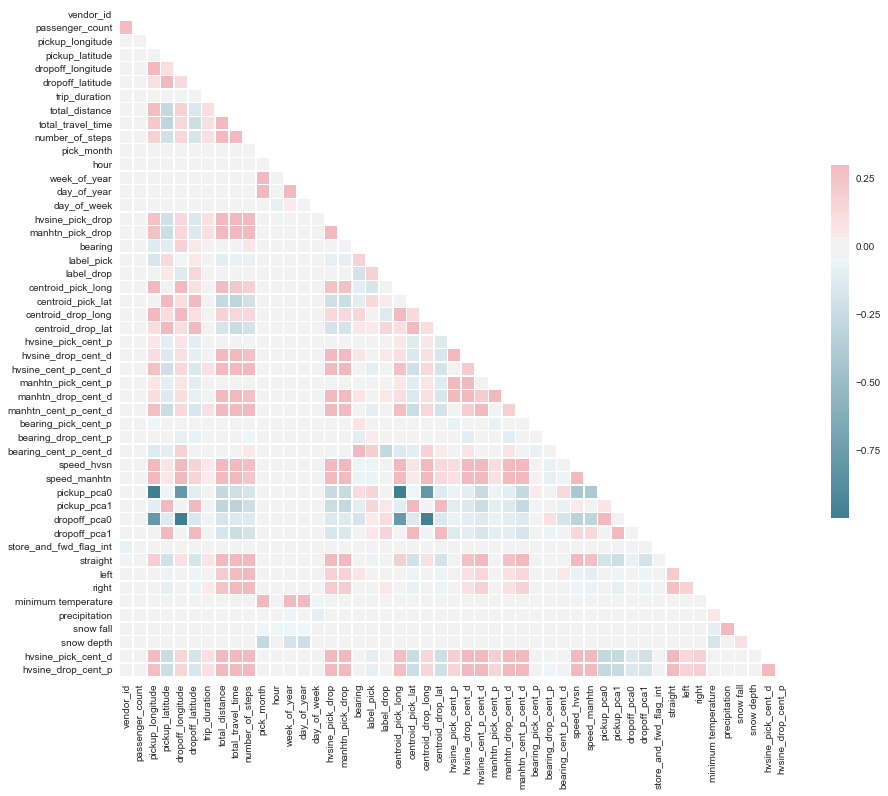

In [88]:
%matplotlib inline

sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()

# Compute the correlation matrix
corr = temp3.corr()

# for the upper triangle: Generate a mask 
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Findings:
### 1. Pick_month, week_of_year, day_of_year etc are of very less importance and are not at all related to other variables.
### 2. Positive correlation & negative correlation
### 3. OSRM variables are very important => correlation is as high as 0.8

## 2.1 Positive Correlation:
### drop_longitude & pickup_longitude 0.8
### dropoff_latitude & pickup_latitude 0.65
### centroid_pick_long & pickup_latitude 0.9
### centroid_pick_lat & pickup_latitude 0.8

## 2.2 Negative Correlation:
### pickup_pca0 & pickup_longitude -0.8

# Sentiment Analysis

## For validation if there is some consistency with the conclusion generated from algorithms.
### Import the necessary methods from tweepy library.

In [89]:
#Import the necessary methods from tweepy library
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
from snownlp import SnowNLP

# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re

%matplotlib inline

#Variables that contain the user credentials to access Twitter API
#(Note: replace with own values from https://apps.twitter.com/)
CONSUMER_KEY='8CfHbmkzWMADgHLiZ8vpYnX5p'
CONSUMER_SECRET ='QyqVrq5z4ZBRmGSMSMf43nt4KommzH7qrGal43HW7rjSVwvsHh'

ACCESS_TOKEN='1639307029-iWG3oEUZwJoBiLwrTsHxspl7YGlGRj1PhGIYk7Y'
ACCESS_SECRET='P3ulSrZk99gcYRMvlLYve89u9JNG10KUr0fX8bZW43FSO'



## Check the key from: https://apps.twitter.com/app/14971757/show

In [90]:
# We import our access keys:
from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

## Define some functions: Create Dataframe,Add Data Feature, getTweet, search Keyword and sentimental analysis.

In [91]:
def searchKeyword(keyword):
    tweets = api.search(keyword)
    return tweets

def createDataFrame(tweets):
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    return data

def getTweetObject(tweets): ## Internal methods of a single tweet object:
    print(dir(tweets[0])) ### The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes.

def AddDataFeature(data, tweets):
    # We add relevant data:## we well just add some data to our dataframe. 
    # For this we will use Pythons list comprehension and a new column will be added to the dataframe 
    # by just simply adding the name of the content between square brackets and assign the content.
    data['len']  = np.array([len(tweet.text) for tweet in tweets])
    data['ID']   = np.array([tweet.id for tweet in tweets])
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Source'] = np.array([tweet.source for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])
    return data
    
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
def analize_sentiment_CHN(tweet):

    analysis = SnowNLP(clean_tweet(tweet))
    if analysis.sentiments.polarity > 0:
        return 1
    elif analysis.sentiments.polarity == 0:
        return 0
    else:
        return -1
    
def addSentimentFeature(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])
    return data

def addSentimentFeature_CHN(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment_CHN(tweet) for tweet in data['Tweets'] ])
    return data
    
def classifyTweets(data):
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]
    return pos_tweets, neu_tweets, neg_tweets



## create an extractor object and call the functions to analysis.

In [92]:
# We create an extractor object:
api = twitter_setup()

keyword="New York traffic"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York traffic tweets extracted: 15.



,Tweets
0,RT @Reuters: 'Smallville' actress charged in s...
1,RT @Reuters: 'Smallville' actress charged in s...
2,RT @Reuters: 'Smallville' actress charged in s...
3,@NYGovCuomo We are one New York. I sit in traf...
4,RT @Reuters: 'Smallville' actress charged in s...
5,RT @Reuters: 'Smallville' actress charged in s...
6,RT @Reuters: 'Smallville' actress charged in s...
7,RT @Reuters: 'Smallville' actress charged in s...
8,RT @Reuters: 'Smallville' actress charged in s...
9,RT @Reuters: 'Smallville' actress charged in s...


After adding features:



,Tweets,len,ID,Date,Source,Likes,RTs
0,RT @Reuters: 'Smallville' actress charged in s...,126,987509347684179968,2018-04-21 01:52:30,Twitter for Android,0,97
1,RT @Reuters: 'Smallville' actress charged in s...,126,987509216830205952,2018-04-21 01:51:58,Twitter for iPhone,0,97
2,RT @Reuters: 'Smallville' actress charged in s...,126,987508980711854080,2018-04-21 01:51:02,Twitter for Android,0,97
3,@NYGovCuomo We are one New York. I sit in traf...,140,987508757096693760,2018-04-21 01:50:09,Twitter for iPhone,0,0
4,RT @Reuters: 'Smallville' actress charged in s...,126,987508521125273602,2018-04-21 01:49:13,Twitter for Android,0,97
5,RT @Reuters: 'Smallville' actress charged in s...,126,987508500669517824,2018-04-21 01:49:08,Twitter for BlackBerry,0,97
6,RT @Reuters: 'Smallville' actress charged in s...,126,987507887256866816,2018-04-21 01:46:41,Twitter for iPhone,0,97
7,RT @Reuters: 'Smallville' actress charged in s...,126,987507784991178752,2018-04-21 01:46:17,Twitter Web Client,0,97
8,RT @Reuters: 'Smallville' actress charged in s...,126,987507441343582209,2018-04-21 01:44:55,Twitter for Android,0,97
9,RT @Reuters: 'Smallville' actress charged in s...,126,987507260497760256,2018-04-21 01:44:12,Twitter for iPhone,0,97


After adding Sentiment Features:



,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,RT @Reuters: 'Smallville' actress charged in s...,126,987509347684179968,2018-04-21 01:52:30,Twitter for Android,0,97,0
1,RT @Reuters: 'Smallville' actress charged in s...,126,987509216830205952,2018-04-21 01:51:58,Twitter for iPhone,0,97,0
2,RT @Reuters: 'Smallville' actress charged in s...,126,987508980711854080,2018-04-21 01:51:02,Twitter for Android,0,97,0
3,@NYGovCuomo We are one New York. I sit in traf...,140,987508757096693760,2018-04-21 01:50:09,Twitter for iPhone,0,0,1
4,RT @Reuters: 'Smallville' actress charged in s...,126,987508521125273602,2018-04-21 01:49:13,Twitter for Android,0,97,0
5,RT @Reuters: 'Smallville' actress charged in s...,126,987508500669517824,2018-04-21 01:49:08,Twitter for BlackBerry,0,97,0
6,RT @Reuters: 'Smallville' actress charged in s...,126,987507887256866816,2018-04-21 01:46:41,Twitter for iPhone,0,97,0
7,RT @Reuters: 'Smallville' actress charged in s...,126,987507784991178752,2018-04-21 01:46:17,Twitter Web Client,0,97,0
8,RT @Reuters: 'Smallville' actress charged in s...,126,987507441343582209,2018-04-21 01:44:55,Twitter for Android,0,97,0
9,RT @Reuters: 'Smallville' actress charged in s...,126,987507260497760256,2018-04-21 01:44:12,Twitter for iPhone,0,97,0


Percentage of New York traffic positive tweets: 13.333333333333334%
Percentage of New York traffic neutral tweets: 86.66666666666667%
Percentage de New York traffic negative tweets: 0.0%


### Same with last session with weather analysis. 

In [93]:
# We create an extractor object:

keyword="New York weather"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York weather tweets extracted: 15.



,Tweets
0,RT @dsantana310: the New York #Yankees are as ...
1,RT @dsantana310: the New York #Yankees are as ...
2,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
3,RT @dsantana310: the New York #Yankees are as ...
4,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
5,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
6,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
7,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
8,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...
9,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...


After adding features:



,Tweets,len,ID,Date,Source,Likes,RTs
0,RT @dsantana310: the New York #Yankees are as ...,76,987509031517458432,2018-04-21 01:51:14,Twitter for iPhone,0,5
1,RT @dsantana310: the New York #Yankees are as ...,76,987508985879146496,2018-04-21 01:51:03,Twitter for Android,0,5
2,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987508581879644160,2018-04-21 01:49:27,Twitter for iPhone,0,2829
3,RT @dsantana310: the New York #Yankees are as ...,76,987508412454981632,2018-04-21 01:48:47,Twitter for iPhone,0,5
4,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987508250122899456,2018-04-21 01:48:08,Twitter for iPhone,0,2829
5,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507550659727360,2018-04-21 01:45:21,Twitter for Android,0,2829
6,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507397387276288,2018-04-21 01:44:45,Twitter for iPhone,0,2829
7,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507128050085889,2018-04-21 01:43:40,Twitter for iPhone,0,2829
8,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987506919106666496,2018-04-21 01:42:51,Twitter for iPhone,0,2829
9,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987506804967067649,2018-04-21 01:42:23,Twitter for iPhone,0,2829


After adding Sentiment Features:



,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,RT @dsantana310: the New York #Yankees are as ...,76,987509031517458432,2018-04-21 01:51:14,Twitter for iPhone,0,5,1
1,RT @dsantana310: the New York #Yankees are as ...,76,987508985879146496,2018-04-21 01:51:03,Twitter for Android,0,5,1
2,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987508581879644160,2018-04-21 01:49:27,Twitter for iPhone,0,2829,1
3,RT @dsantana310: the New York #Yankees are as ...,76,987508412454981632,2018-04-21 01:48:47,Twitter for iPhone,0,5,1
4,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987508250122899456,2018-04-21 01:48:08,Twitter for iPhone,0,2829,1
5,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507550659727360,2018-04-21 01:45:21,Twitter for Android,0,2829,1
6,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507397387276288,2018-04-21 01:44:45,Twitter for iPhone,0,2829,1
7,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987507128050085889,2018-04-21 01:43:40,Twitter for iPhone,0,2829,1
8,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987506919106666496,2018-04-21 01:42:51,Twitter for iPhone,0,2829,1
9,RT @Kuerstin_M: I am a:\n\n⚪️ male\n⚪️ female\...,130,987506804967067649,2018-04-21 01:42:23,Twitter for iPhone,0,2829,1


Percentage of New York weather positive tweets: 100.0%
Percentage of New York weather neutral tweets: 0.0%
Percentage de New York weather negative tweets: 0.0%


## The code in the document by Ziwei Fan is licensed under the MIT License：https://opensource.org/licenses/MIT

In [94]:
from IPython.core.display import display, HTML
display("The text is released under the ", 
         HTML("""<a href="https://creativecommons.org/licenses/by/3.0/us/">CC-BY-NC-ND</a>"""),
        "license, and code is released under the ",
        HTML("""<a href="https://opensource.org/licenses/MIT">MIT license</a>"""))


'The text is released under the '

'license, and code is released under the '

## MIT license:
## Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
## documentation files (the "Software"), to deal in the Software without restriction, 
## including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
## and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, 
## subject to the following conditions:

## The above copyright notice and this permission notice shall be included in all copies or substantial portions of 
## the Software.